# 1.Motivation
The following project aim to allow the user to gain an understanding of the community
of painters within Europe.<br>

Italy and France are both nations whit greate importance for the european art history, 
and are both birth places for many famouse artist. Therefore the project will be centered around these two nations,
as well as Denmark, which is included to offer a perspective of a smaller nation, as well as familiar frame of refference.

The dataset consist of the wikipida pages of the painters, who are listed on the following wikipidia pages:
- *List of French painters*: https://en.wikipedia.org/wiki/List_of_French_painters (visited 9.12.2020).
- *List of Italian painters*: https://en.wikipedia.org/wiki/List_of_Italian_painters (visited 9.12.2020).
- *List of Danish painters*: https://en.wikipedia.org/wiki/List_of_Danish_painters (visited 9.12.2020).

While the list of painters are not exhaustive, the nature of wikipida mean that the most
important painters are likely to have been included. In addition the list of painters also
included information about the when the painters are born. This information will be extracted to
allow for an exploration of the painters community as it has evolved over time.

The data will be suplemented by a list of art movements, which also have been extracted 
from wikipidia:
- *List of art movements*: https://en.wikipedia.org/wiki/List_of_art_movements (visited 9.12.2020).

The information allow painters association to art movements to be extracted.

At last a list of cities in Europe will in a similar way be included, to determine geographical connections.
- *List of All Cities in Europe Alphabetically*: http://ontheworldmap.com/europe/cities/ (visited 9.12.2020).


# 2.Basic stats

## 2.1 Getting the data set

In [1]:
import pandas as pd
import numpy as np
import json
from urllib.parse import quote
from urllib.request import urlopen
import re
import networkx as nx
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import requests
from bs4 import BeautifulSoup
import community
from community import community_louvain
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
%matplotlib inline

As our data mainly consist of wiki pages we below define a funcion for retriving a wikipidia page, using the title of the page.

In [2]:
def get_wiki_page(link_title):
    #define query
    title='titles={}'.format(quote(link_title))
    baseurl="https://en.wikipedia.org/w/api.php?"
    action='action=query'
    content="prop=revisions&rvprop=content"
    dataformat="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

    #retrive response
    response = urlopen(query)
    wikidata = response.read()
    wikiPage = wikidata.decode('utf-8')
    wiki_source=json.loads(wikiPage)

    #get the page
    page=wiki_source['query']['pages']
    page_id=next(iter(page))
    page=page[page_id]['revisions'][0]['*']

    return page

### 2.1.1 Extracting list of painters with nationality and year

The painters are extracted from list of painters.

In [3]:
Danish_Painters_list=get_wiki_page('List_of_Danish_painters')
French_Painters_list=get_wiki_page('List_of_French_painters')
Italian_Painters_list=get_wiki_page('List_of_Italian_painters')

We are only interested in a subset of each page. For instance the page listing french painters, do so both alphabetically and then by century. Therefore we now extract the relevent sections of each page.

In [4]:
regex_french_sections=r'==alphabetically==([\s,\S]*?)== By century =='
regex_dainsh_itallian_sections=r'==A==([\s,\S]*?)==See also=='

Danish_Painters_list=re.findall(regex_dainsh_itallian_sections,Danish_Painters_list)[0]
French_Painters_list=re.findall(regex_french_sections,French_Painters_list)[0]
Italian_Painters_list=re.findall(regex_dainsh_itallian_sections,Italian_Painters_list)[0]

The painters are listed as links connecting to their corresponding wiki pages. Therefore all links identified using regular expressions. Furthermore we are interested in obtaining the birth year of each painter. This information is listed next to each painter, and can therefore be identified throug the regular expressin as well.

In [5]:
regex_link_year=r'(\[\[[^\]]*\]\]) (\(\D*(\d\d\d\d))?'
Danish_Painters_list=re.findall(regex_link_year, Danish_Painters_list)
French_Painters_list=re.findall(regex_link_year, French_Painters_list)
Italian_Painters_list=re.findall(regex_link_year, Italian_Painters_list)

The information is now collected in Pandas dataframes.

In [6]:
DanishPainters=pd.DataFrame(Danish_Painters_list,columns=['Links',"test","birth_year"])
FrenchPainters=pd.DataFrame(French_Painters_list,columns=['Links',"test","birth_year"])
ItalianPainters=pd.DataFrame(Italian_Painters_list,columns=['Links',"test","birth_year"])

In [7]:
DanishPainters=DanishPainters.drop(['test'],axis=1)
FrenchPainters=FrenchPainters.drop(['test'],axis=1)
ItalianPainters=ItalianPainters.drop(['test'],axis=1)

The three dataframes are now combined, while introducing a nationality column to retain the information about the countires. 

In [8]:
DanishPainters["nationality"]="Danish"
FrenchPainters["nationality"]="French"
ItalianPainters["nationality"]="Italian"

In [9]:
Painters=pd.concat([DanishPainters,FrenchPainters,ItalianPainters])

For the extracted links to be useful it is necessary to further clean them up. For pages where the name differ from the titles two values will be listed. The next step is therefore to identify the link and name for each painter.

In [10]:
regex_link='\[\[([^\[,\],\|]+)\|?([^\[,\],\|]*?)\]\]'
Painters['Divided_links']=Painters.Links.apply(lambda l: re.findall(regex_link, l))

In [11]:
def extract_name(link):
    name=link[0][1]
    if name=='':
        name=link[0][0]
    return name

In [12]:
Painters['wikiLinks']=Painters.Divided_links.apply(lambda l:l[0][0])
Painters['Name']=Painters.Divided_links.apply(lambda l:extract_name(l))

#drop temporary columns
Painters=Painters.drop(['Links','Divided_links'],axis=1)
#drop duplicate painters
Painters=Painters.drop_duplicates()

In [13]:
Painters=Painters.sort_values('birth_year', ascending=False).drop_duplicates('Name').sort_index()

At last we address the issue of painters listed for more than one country. This is done by letting their nationality be listed as both.

In [14]:
Painters=Painters.set_index("Name")
Painters['nationality']=Painters.groupby(level=0)['nationality'].sum()
Painters=Painters.drop_duplicates(subset='wikiLinks',keep='first')

### 2.1.2  Collecting wikipidia pages

A function is created to dowload the wikipages for each painter. The function indicates wheter or not such a download is successful, to avoid painters with non-valid links.

In [15]:
def dowloadWikiPage(folder,name,wikiLink):
    #Use API to send query for page
    quoted_link=quote(wikiLink)
    action='action=query'
    content="prop=revisions&rvprop=content"
    dataformat="format=json"
    baseurl="https://en.wikipedia.org/w/api.php?"
    title = "titles={}".format(quoted_link)
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    wikiresponse = urlopen(query)
    wikidata = wikiresponse.read()
    wikiPage = wikidata.decode('utf-8')    
    wiki_source=json.loads(wikiPage)
    #Painters.loc[painter.index,'wikiLinks']="new_title"
    
    try:
        #Extract page content
        page=wiki_source['query']['pages']
        page_id=next(iter(page))
        page=page[page_id]['revisions'][0]['*']

        # test if the link is redirecting to another page
        regex_redirect=r'#REDIRECT \[\[(.*)\]\]'
        new_title=re.findall(regex_redirect,page)
        if new_title!=[]:
            new_title=new_title[0]
            #update link to correpond to the redirected page.
            Painters.at[name,'wikiLinks']=new_title
            quoted_link=quote(new_title)
            title = "titles={}".format(quoted_link)
            query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
            wikiresponse = urlopen(query)
            wikidata = wikiresponse.read()
            wikiPage = wikidata.decode('utf-8')    
            wiki_source=json.loads(wikiPage)
            page=wiki_source['query']['pages']
            page_id=next(iter(page))
            page=page[page_id]['revisions'][0]['*']
           

        #Save page content in file
        file = open(folder+"/"+name,"w",encoding='utf-8')
        file.write(page)
        file.close()
        return True
    # If page don't exist
    except:
        return False
        pass

In [16]:
has_page=[]
for index, row in Painters.iterrows():
    has_page.append(dowloadWikiPage('Painters',index,row['wikiLinks']))

In [17]:
Painters['downloaded']=has_page

#remove all painters who did not have a working link
Painters=Painters[Painters.downloaded]

### 2.1.3 Identifying connections between painters

In the following section we will be identifying connections between painters. This is done by finding all links within each painters page, reffering to another painters wikipidia page. 

In [18]:
Painters['connections']=''

for index, row in Painters.iterrows():
    try:
        page_content=open('Painters/'+index,'r',encoding='utf-8').read()
        Painters.at[index,'connections']=re.findall(regex_link,page_content)
    except:
        Painters.at[index,'connections']=[]

In [19]:
Painters['Painter_links']=Painters.apply(lambda l: [connection[0] for connection in (l['connections'])if (connection[0] in Painters.wikiLinks)],axis=1)

## 2.2 Building the initial network

The initial network can now be build. Here painters will be modeled as nodes, and edges corresponds to
a link on one painters wikipedia page, pointing to another painters webpages. This also mean that links are directed in 
nature, and the network will therefore be directed.<br>
In the initial network the nationality and and birth year is saved as node attributes.

In [20]:
# initializing network
Painter_network=nx.DiGraph()

#adding a node for each painter
Painter_network.add_nodes_from(Painters.index)

#adding edges
for painter in Painter_network.nodes():
    Painter_network.nodes()[painter]["nationality"]=Painters.loc[painter,"nationality"]
    Painter_network.nodes()[painter]["birth_year"]=Painters.loc[painter,"birth_year"]
    for target in Painter_network.nodes():     
        #if painter links to target, then add edge from character node to target node
        if Painters.loc[target,'wikiLinks'] in Painters.loc[painter,'Painter_links']:
            Painter_network.add_edge(painter, target)

Below the network is illustrated, with colors indicating nationality.

In [21]:
#Assign colors to nationality
national_color_map={'Danish':'r','French':'b','DanishFrench':'m','Italian':'g'}

#get positions
forceatlas2 = ForceAtlas2()
positions = forceatlas2.forceatlas2_networkx_layout(Painter_network)

100%|██████████| 100/100 [00:00<00:00, 104.97it/s]BarnesHut Approximation  took  0.39  seconds
Repulsion forces  took  0.50  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds



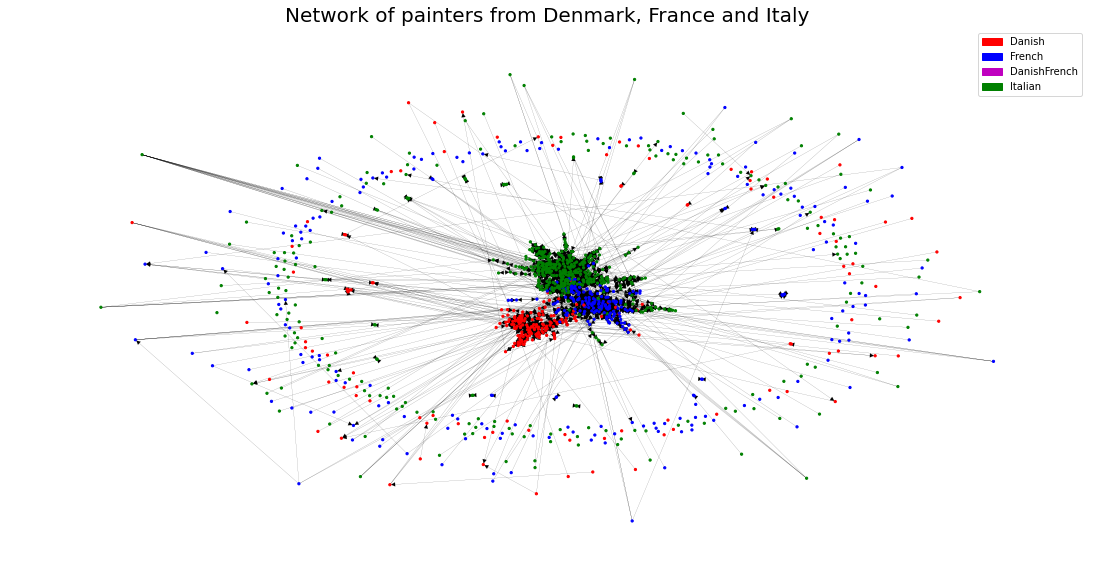

In [22]:
#Create network
plt.figure(figsize=(15,7.5))
nx.draw(Painter_network,positions,node_color=[national_color_map[t] for t in [Painter_network.nodes()[node]['nationality'] for node in Painter_network]],node_size=5,width=0.1,label=nx.get_node_attributes(Painter_network,'Nationality'))
plt.title("Network of painters from Denmark, France and Italy", fontsize=
20)
plt.legend(handles=[mpatches.Patch(color=national_color_map[key],label=key) for key in national_color_map.keys()])
plt.show()

The above illustration of the painters network show that the network is centered around a
a group of well connected nodes, which internally appear to be especially within groups of painters beloning to the same  country. In addition to thess the network also consist of nodeswhoch appear to be less connected, with no edges at all or only outgoing edges.

## 2.3 Stats of the initial network

Now that the initial netwrok has been corrected we are ready to get an inital understanding of the network.

In [23]:
print("The number of nodes:",len(Painter_network.nodes))
print("The number of edges:",len(Painter_network.edges))

The number of nodes: 1153
The number of edges: 2691


In [24]:
#extract in/out degree#
degree_in=[d for n, d in Painter_network.in_degree()]
degree_out=[d for n, d in Painter_network.out_degree()]
degree_count_in,bins_in=np.histogram(degree_in,bins=np.arange(1,np.max(degree_in)+2))
degree_count_out,bins_out=np.histogram(degree_out,bins=np.arange(1,np.max(degree_out)+2))

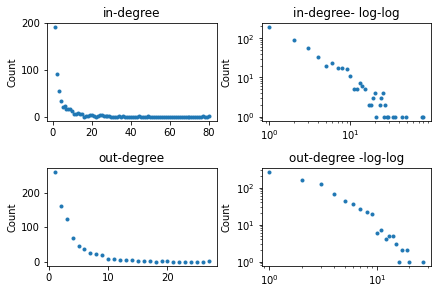

In [25]:
#Plot degree
ax1 = plt.subplot(221)
plt.plot(np.arange(1,np.max(degree_in)+1),degree_count_in,'o',markersize=3)
plt.ylabel("Count")
plt.title("in-degree")

ax2=plt.subplot(222)
plt.plot(np.arange(1,np.max(degree_in)+1),degree_count_in,'o',markersize=3)
plt.ylabel("Count")
plt.xscale('log')
plt.yscale('log')
plt.title("in-degree- log-log")

ax3=plt.subplot(223)
plt.plot(np.arange(1,np.max(degree_out)+1),degree_count_out,'o',markersize=3)
plt.ylabel("Count")
plt.title("out-degree")

ax4=plt.subplot(224)
plt.plot(np.arange(1,np.max(degree_out)+1),degree_count_out,'o',markersize=3)
plt.ylabel("Count")
plt.xscale('log')
plt.yscale('log')
plt.title("out-degree -log-log")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()


We could conclude from above plots:
- There is a positive corrolation between the in degrees and out degrees, which means that a high in degree increases the probability that the character also has a high out degree.
- Although most nodes have a very small degree, there are a few nodes with a very large degree. This indicates the presence a few nodes or painters that are highly connected to other ones in the network.
- There are around 200 nodes without in-degree, while near 250 are without out-degree.This means there are less painters who wasn't mentioned by others than those who never metntion others. Well-know painters tend to have more in-degree and out-degree. Those with few degrees may be defined as un-famous.
- The log-log plots of the distributions demonstrate that the network has power-law degree distributions since the scatter points tend to fall along lines. Networks with such distributions are called scale-free since power laws have the same functional form at all scales. In this network, it means that every time a new painter is added to the network, the number of painters it can be connected to increases.


In [26]:
#Most connected nodes
print("Mosted connected painters:")
print('---------------------------')
print()
print("For in-degrees:")
print('-----------------')
for node in sorted(Painter_network.in_degree, key=lambda x: x[1], reverse=True)[0:5]:
    print("- {}: {}".format(node[0],node[1]))
print()    
print("For out-degrees:")
print('-----------------')
for node in sorted(Painter_network.out_degree, key=lambda x: x[1], reverse=True)[0:5]:
    print("- {}: {}".format(node[0],node[1]))

Mosted connected painters:
---------------------------

For in-degrees:
-----------------
- Giorgio Vasari: 80
- Raphael: 77
- Titian: 49
- Michelangelo: 44
- Christoffer Wilhelm Eckersberg: 36

For out-degrees:
-----------------
- Christoffer Wilhelm Eckersberg: 27
- Giovanni Santi: 20
- Nicolas Poussin: 19
- Leonardo Da Vinci: 19
- Annibale Carracci: 17


Painters with bigger in-degrees  potentially mean his/her influence on others' art style is larger. Painters with bigger out-degrees show that their art achievenments may have high coorelation with other painters.

The result of mosted connected painters verifies the above assumption. We could see the first four painters in in-degree part are all well-know Italian painters of the High Renaissance. And Christoffer Wilhelm Eckersberg is referred to as the Father of Danish painting. At the same time, we could also conclude the Italian painters of High Renaissance have huge influence on the Eroupen art style. And compared to Italy, Denmark in art history has less influential figures.

We also curious why the danish painter Christoffer Wilhelm Eckersberg has the higest out-degree, aftering checking out his wikipage we leaned he traveled a lot during his young age period to learn art. Hence it makes resonable sense that his art style was influenced by other painters a lot.

This analysis shed ligh on how to investigate reltionship among different painters.

In [27]:
#Gcc
largest_cc = max(nx.weakly_connected_components(Painter_network), key=len)
GCC = Painter_network.subgraph(largest_cc)

In [28]:
print(f"Number of nodes in GCC: {GCC.number_of_nodes()}")
print(f"Number of edges in GCC: {GCC.number_of_edges()}")

Number of nodes in GCC: 816
Number of edges in GCC: 2674


# 3.Tools, theory and analysis
In this section we will focus on obtaining a deeper understanding of the painters network.

## 3.1 Identifying communities

In order to find and anaylse the communities of our painters network, we will start by computing the modularity of it to see whether we have a good partition which implies a community structure. We will initialized the subgraph from our network based on the nationality of painters

In [29]:
French_nodes=[]

for node in Painter_network.nodes():
    if  Painter_network.nodes[node]['nationality']=='French':
        French_nodes.append(node)

French_subgraph=Painter_network.subgraph(French_nodes)       

In [30]:
Danish_nodes=[]

for node in Painter_network.nodes():
    if  Painter_network.nodes[node]['nationality']=='Danish':
        Danish_nodes.append(node)

Danish_subgraph=Painter_network.subgraph(Danish_nodes)       

In [31]:
Italian_nodes=[]

for node in Painter_network.nodes():
    if  Painter_network.nodes[node]['nationality']=='Italian':
        Italian_nodes.append(node)

Italian_subgraph=Painter_network.subgraph(Italian_nodes)       

In [32]:
DanishFrench_nodes=[]

for node in Painter_network.nodes():
    if  Painter_network.nodes[node]['nationality']=='DanishFrench':
        DanishFrench_nodes.append(node)

DanishFrench_subgraph=Painter_network.subgraph(DanishFrench_nodes) 

By computing the edges of networks, we can compute the modularity of our 4 communities based on the formula 9.12 from [Network Science by Albert-lászló Barabási, chapter 9](http://networksciencebook.com/chapter/9#modularity)
![](pics/Modularity.jpg)

In [33]:
#Calculate the modularity 
L=len(Painter_network.edges())
L_french=len(French_subgraph.edges())
L_danish=len(Danish_subgraph.edges())
L_italian=len(Italian_subgraph.edges())
L_danishfrench=len(DanishFrench_subgraph.edges())

K_french=sum([x for _,x in French_subgraph.degree()])
K_danish=sum([x for _,x in Danish_subgraph.degree()])
K_italian=sum([x for _,x in Italian_subgraph.degree()])
K_danishfrench=sum([x for _,x in DanishFrench_subgraph.degree()])
M = ((L_french/L)-(K_french/(2*L)**2)+(L_danish/L)-(K_danish/(2*L)**2)+(L_danishfrench/L)-(K_danishfrench/(2*L)**2)+(L_italian/L)-(K_italian/(2*L)**2))

print(M)

0.9162176908287131


Generally, the modularity should range in [-1,1]. Networks with high modulJarity have dense connections between the nodes within modules but sparse connections between nodes in different modules.[1] https://en.wikipedia.org/wiki/Modularity_(networks). In this case, the rounded 0.9 modularity is a fair number to verify these communities are good and tightly knit.

The we will use the Python Louvain-algorithm implementation to find communities in each network and combine them as all communities in whole network.

In [34]:
#Transfer all dirtected graph to non directed graph
French_subgraph=French_subgraph.to_undirected()
partition_french=community_louvain.best_partition(French_subgraph)
modularity_french = community_louvain.modularity(partition_french,French_subgraph)

Danish_subgraph=Danish_subgraph.to_undirected()
partition_danish=community_louvain.best_partition(Danish_subgraph)
modularity_danish = community_louvain.modularity(partition_danish,Danish_subgraph)

Italian_subgraph=Italian_subgraph.to_undirected()
partition_italian=community_louvain.best_partition(Italian_subgraph)
modularity_italian = community_louvain.modularity(partition_italian,Italian_subgraph)

#DanishFrench_subgraph=DanishFrench_subgraph.to_undirected()
#partition_danishfrench=community_louvain.best_partition(DanishFrench_subgraph)
#modularity_danishfrench = community_louvain.modularity(partition_danishfrench,DanishFrench_subgraph)


## for whole nerwork
Painter_network=Painter_network.to_undirected()
partition_whole_network=community_louvain.best_partition(Painter_network)
modularity_whole_network = community_louvain.modularity(partition_whole_network,Painter_network)

print(modularity_whole_network)
# 0.670 stands for a relatively clear communities in painters network
#print('modularity_danish:' + modularity_danish)
#print('modularity_italian:' + modularity_italian)
#print('modularity_danishfrench:' + modularity_danishfrench )



0.6625046550389759


```
    Then we will visualize the communities of our network and count their size of communities. Using the python Louvain-network
```

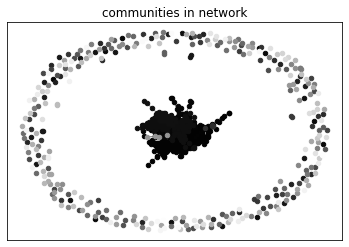

In [35]:

size = float(len(set(partition_whole_network.values())))
pos = nx.spring_layout(Painter_network)
count = 0
for com in set(partition_whole_network.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition_whole_network.keys()
                                if partition_whole_network[nodes] == com]
    nx.draw_networkx_nodes(Painter_network, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(Painter_network,pos, alpha=0.5)
plt.title('communities in network')
plt.show()

In [36]:
print("We can see from above, there  {} communities in were identified.".format(size))

We can see from above, there  338.0 communities in were identified.


In [37]:
communitylist=partition_whole_network.values()

In [38]:
distribution ={k:list(communitylist).count(k) for k in communitylist}
print(distribution)

{0: 89, 1: 179, 2: 15, 3: 159, 4: 1, 5: 23, 6: 1, 7: 1, 8: 73, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 112, 18: 1, 19: 79, 20: 79, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 2, 30: 1, 31: 1, 32: 2, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 4, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 2, 72: 1, 73: 1, 74: 1, 75: 2, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 2, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 135: 1, 136: 1, 1

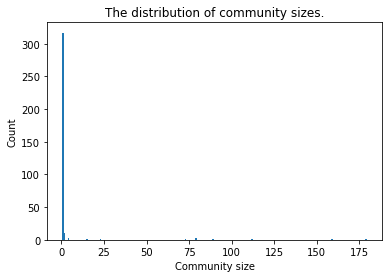

In [39]:
plt.bar(pd.Series(list(distribution.values())).value_counts().index , pd.Series(list(distribution.values())).value_counts())
plt.xlabel("Community size")
plt.ylabel("Count")
plt.title("The distribution of community sizes.")
plt.show()

```
The size of community size is under huge deviation. Above 300 communities only contain 1 node in their communities. Let's remove the them and check the plot again.
```

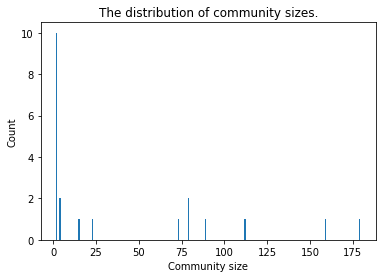

In [40]:
distribution_better = {k:list(communitylist).count(k) for k in communitylist if list(communitylist).count(k) > 1}
plt.bar(pd.Series(list(distribution_better.values())).value_counts().index , pd.Series(list(distribution_better.values())).value_counts())
plt.xlabel("Community size")
plt.ylabel("Count")
plt.title("The distribution of community sizes.")
plt.savefig("community.jpg")
plt.show()

```
    From here we can conclude 10 communities which are only contain 2 nodes in them. Based on this plot we will choose the best community.
```

In [41]:
#Automatically choose the five largest communities
print('5 largest communities in painter')
sorted(distribution_better,key=distribution_better.get,reverse =True)[:5]

5 largest communities in painter


[1, 3, 17, 0, 19]

## 3.2 Characterizing the national communities

As the previous analysis revealed nationality provides a good divition of the network into communities. In the following we will therefore seek to understand the three national communities better.

### 3.2.1 Community sizes
To get an initial understanding of the communities we take a look at how they vary in size.

In [42]:
print('Number of painters in national communities:')
number_painters_french=len(French_nodes)
number_painters_italian=len(Italian_nodes)
number_painters_danish=len(Danish_nodes)
print('France:', number_painters_french)
print('Italy;', number_painters_italian)
print('Denmark:', number_painters_danish)

Number of painters in national communities:
France: 351
Italy; 546
Denmark: 256


It is cleare that the size of the communities varries for each country, and whit the 
Italian community being more that twice as large as the Danish community, this is something
to keep in mind as we continue with the analysis.

### 3.2.1 Extracting clean web pages
The approach to charaterizing the national communities are centered around text-analysis and 
the first step is therefore to obtain the webpages. While the wikipidia pages for the painters
were already downloaded initially these included the markup of the pages, which was necessary
to be able to identify links. However for the following text-analysis the markup of the pages
represent a disturbing element, and clean versions of each page are therefore dowloaded. 

Documentation for the extention used to extract the clean version of the wikipidia pages are found here:
https://www.mediawiki.org/wiki/Extension:TextExtracts#query+extracts (visited 4.12.202)

In [43]:
def dowloadCleanWikiPage(folder,name,wikiLink):
    #Use API to send query for page
    quoted_link=quote(wikiLink)
    action='action=query'
    content='prop=extracts&explaintext' #get clean text version of page
    dataformat="format=json"
    baseurl="https://en.wikipedia.org/w/api.php?"
    title = "titles={}".format(quoted_link)
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    wikiresponse = urlopen(query)
    wikidata = wikiresponse.read()
    wikiPage = wikidata.decode('utf-8')    
    wiki_source=json.loads(wikiPage)
    page=wiki_source['query']['pages']
    page_id=next(iter(page))
    page=page[page_id]['extract']
 
    #Save page content in file
    file = open(folder+"/"+name,"w",encoding='utf-8')
    file.write(page)
    file.close()

In [44]:
for index, row in Painters.iterrows():
    dowloadCleanWikiPage('Painters_clean',index,row['wikiLinks'])

We now combine the pages to from three documents, representing each of the three national communites.

In [45]:
French_pages=''
Danish_pages=''
Italian_pages=''

for name in French_nodes: 
    French_pages+=open("Painters_clean/"+name, encoding='utf8').read().lower()+' '
for name in Danish_nodes: 
    Danish_pages+=open("Painters_clean/"+name, encoding='utf8').read().lower()+ ' '
for name in Italian_nodes: 
    Italian_pages+=open("Painters_clean/"+name, encoding='utf8').read().lower()+' '

### 3.2.3 Pre-processing of text

The first step in order to prepare the text for analysis, is to extract the tokens, and
exclude punctuation. This is done using the regular expression: **\[\w \\-\]+**.
This match all words removing puntation, but allow for the symbol " - " to be included
to take into account words such as *neo-impressionism* which we do not wish to split. 

In [46]:
#get tokens without punctation.
French_tokens=nltk.regexp_tokenize(French_pages.lower(),'[\w\-]+') 
Danish_tokens=nltk.regexp_tokenize(Danish_pages.lower(),'[\w\-]+') 
Italian_tokens=nltk.regexp_tokenize(Italian_pages.lower(),'[\w\-]+')

The preprocessing continues by removing all stopwords.

In [47]:
#remove stopwords
stopwords_english=stopwords.words('english')
French_tokens=[token for token in French_tokens if token not in stopwords_english]
Danish_tokens=[token for token in Danish_tokens if token not in stopwords_english]
Italian_tokens=[token for token in Italian_tokens if token not in stopwords_english]


The last step before the data is ready for analysis to find the stem of the words.

In [48]:
#get the stem of each word
porter=nltk.PorterStemmer()
French_tokens=[porter.stem(token) for token in French_tokens]
Danish_tokens=[porter.stem(token) for token in Danish_tokens]
Italian_tokens=[porter.stem(token) for token in Italian_tokens]

### 3.2.4 TF-TR
In order to understand the what is important for each document and thereby indirectly also
which are important for each of the communities, we need to be able to weight each term.
While TF-IDF can be used for this purpose it has been deselected in this case, as with only three
documents the IDF would only have three possible values. The result of there only being three
different weights is that the frequency of each word (TF), becomes much more important in
determining how important a word is for a document.<br>
In stead the approach here will be based on the TF-TR approach as described by Sune Lehmann Jørgensen
(https://nbviewer.jupyter.org/github/socialcomplexitylab/socialgraphs2020/blob/master/lectures/Week7.ipynb?flush_cache=Ttrue ,visited 4.12.2020).
The term ratio has been updated to take into account the increass from two to three documents, and is presented below:

- let $w$ be a word.
- let $n$ be the country we are interested in
- let $C$ be the set of countries.
- let $c$ be a small constant.

Then the term ration is calculated using the following formula.

$TR_{w,n}=\frac{TF_{w,n}}{c+\sum_{i \in (n \backslash C) } TF_{w,i} }$

As the term frequencies adjusted for length are used, the TF-termes are very small numbers.
Based on this the value of $c$ is set to $0.001$ in the following.

In [49]:
French_document_length=len(French_tokens)
Danish_document_length=len(Danish_tokens)
Italian_document_length=len(Italian_tokens)
print("Document lengths for each community:")
print("French:",French_document_length)
print("Danish:",Danish_document_length)
print("Italian:",Italian_document_length)

Document lengths for each community:
French: 204053
Danish: 70011
Italian: 253866


The first step is to calculate the term frequency (TF). As can be seen above the documents
vary in size with the Danish document being more than half as short as the documents for 
France and Italy. To compensate for this difference we use the term frequency adjusted
for document length (https://en.wikipedia.org/wiki/Tf%E2%80%93idf, vistied .12.2020)



In [50]:
#Terme frequency adjusted for document length
French_tokens=pd.DataFrame(French_tokens)[0].value_counts()/French_document_length
Danish_tokens=pd.DataFrame(Danish_tokens)[0].value_counts()/Danish_document_length
Italian_tokens=pd.DataFrame(Italian_tokens)[0].value_counts()/Italian_document_length

#The term frequencys are transformed to pandas dataframes to ease the continouse work
French_tokens=pd.DataFrame({'TF_adjusted':French_tokens})
Danish_tokens=pd.DataFrame({'TF_adjusted':Danish_tokens})
Italian_tokens=pd.DataFrame({'TF_adjusted':Italian_tokens})

We are now ready to calculate the term ratio

In [51]:
def get_TR(token,c,country):
    TF_others=0
    if country=='France':
        TF=French_tokens.loc[token,'TF_adjusted']
        if token in Danish_tokens.index.values.tolist():
            TF_others+=Danish_tokens.loc[token,'TF_adjusted']
        if token in Italian_tokens.index.values.tolist():
            TF_others+=Italian_tokens.loc[token,'TF_adjusted']
    if country=='Italy':
        TF=Italian_tokens.loc[token,'TF_adjusted']
        if token in Danish_tokens.index.values.tolist():
            TF_others+=Danish_tokens.loc[token,'TF_adjusted']
        if token in French_tokens.index.values.tolist():
            TF_others+=French_tokens.loc[token,'TF_adjusted']
    if country=='Denmark':
        TF=Danish_tokens.loc[token,'TF_adjusted']
        if token in Italian_tokens.index.values.tolist():
            TF_others+=Italian_tokens.loc[token,'TF_adjusted']
        if token in French_tokens.index.values.tolist():
            TF_others+=French_tokens.loc[token,'TF_adjusted']       

    return TF/(TF_others+c)

In [52]:
Danish_tokens['TR']=Danish_tokens.apply(lambda l:get_TR(l.name,0.001,'Denmark'),axis=1)
French_tokens['TR']=French_tokens.apply(lambda l:get_TR(l.name,0.001,'France'),axis=1)
Italian_tokens['TR']=Italian_tokens.apply(lambda l:get_TR(l.name,0.001,'Italy'),axis=1)

The TF-TR can now be calculated.

In [53]:
Danish_tokens['TF-TR']=Danish_tokens.TF_adjusted*Danish_tokens.TR
French_tokens['TF-TR']=French_tokens.TF_adjusted*French_tokens.TR
Italian_tokens['TF-TR']=Italian_tokens.TF_adjusted*Italian_tokens.TR

Now that each word has been ranked, we are ready to take a closer look at which words are important
for each of the national communities.

In [54]:
print('Top 10 words for French painters community:')
n=1
for term in French_tokens.sort_values('TF-TR',ascending=False)[:10].index:
    print(n,'.',term)
    n+=1

Top 10 words for French painters community:
1 . de
2 . le
3 . pari
4 . french
5 . la
6 . salon
7 . franc
8 . paint
9 . art
10 . work


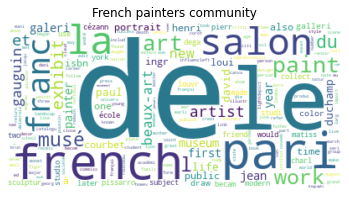

In [55]:
wordcloud_French=WordCloud(background_color="white")
wordcloud_French.generate_from_frequencies(French_tokens['TF-TR'])
plt.imshow(wordcloud_French, interpolation='bilinear')
plt.title("French painters community")
plt.axis("off")
plt.savefig('fcloud.jpg')
plt.show()

As the top-10 for the french painters community show common french words have received a high ranking. Even with the Wikipedia pages being in English, these words can for instance
have been part of titles of paintings. However, they don't offer much information about the french painters community. Continuing through the top-10 we find words connected to France,
which are therefore also a part of the french painter community. *"salon"* is also mentioned, and upon further investigation *Salon* is used to refer to an important art exhibition which used to be held in Paris (https://en.wikipedia.org/wiki/Salon_(Paris), visited 4.12.2020). This in combination
with *"exhibit"* which is also prominently showed in the word cloud, indicates that it has been central within the french painters community. It is also and an indication of the showings of the art is important
with words such as *"galeri"*,"galleri"* and *"public" all being visible in the wordcloud.<br>
At last, we see references to important artists. Here Gauguin is the most highlighted one (https://en.wikipedia.org/wiki/Paul_Gauguin, visited 4.12.2020).


In [56]:
print('Top 10 words for Italian painters community:')
n=1
for term in Italian_tokens.sort_values('TF-TR',ascending=False)[:10].index:
    print(n,'.',term)
    n+=1

Top 10 words for Italian painters community:
1 . di
2 . fresco
3 . italian
4 . st
5 . giovanni
6 . san
7 . florenc
8 . madonna
9 . work
10 . paint


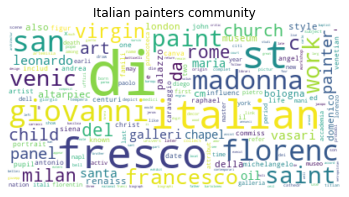

In [57]:
wordcloud_Italian=WordCloud(background_color="white")
wordcloud_Italian.generate_from_frequencies(Italian_tokens['TF-TR'])
plt.imshow(wordcloud_Italian, interpolation='bilinear')
plt.title("Italian painters community")
plt.axis("off")
plt.savefig('icloud.jpg')
plt.show()

From both both the top-10 and the wordcloud it is clear that it is espessicaly differentiate it self
from the two other national communities, by having a focus on religious elements.
This is highlighted through the prominence of words such as; *"fresco"*, *"madonna"*, *"saint"*, *"chapel"*, *"church"*,
*"maria"*, *virgin"* and *"christ*".<br>
Furthermore certain geographical locations appear to be important for the Italian painters
community. These are *"florenc"*, *"milan"*,*"venic"*,,*"rome"* and *"bologna"*.

In [58]:
print('Top 10 words for Danish painters community:')
n=1
for term in Danish_tokens.sort_values('TF-TR',ascending=False)[:10].index:
    print(n,'.',term)
    n+=1

Top 10 words for Danish painters community:
1 . danish
2 . copenhagen
3 . denmark
4 . academi
5 . paint
6 . royal
7 . painter
8 . work
9 . art
10 . travel


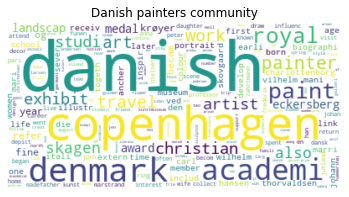

In [59]:
wordcloud_Danish=WordCloud(background_color="white")
wordcloud_Danish.generate_from_frequencies(Danish_tokens['TF-TR'])
plt.imshow(wordcloud_Danish, interpolation='bilinear')
plt.title("Danish painters community")
plt.axis("off")
plt.savefig('dcloud.jpg')
plt.show()

When observing the words describing the Danish art community the connection to the royal family stands out. This is of course highlighted by the word *"royal"* but also *"christan"* which is a common king name.
The prominence of the word travel also indicates that the Danish painters community is characterized by a higher degree of going beyond the national borders. While *"copenhagen"*  is ranked very highly
also *"Skagen"* can be seen, capturing the importance of *the Skagen Painters* within the Danish painters community.
This is further captured with names such as *"krøyer"* and *"ancher"*.  

### 3.2.5 Art movements within the national communities
In order to further understand the national communities, we will here take a look at how the art movements are represented within each community.<br>

#### 3.2.5.1 Determine painters association with art movements

In this section we identify which art movements each painter has been associated with.
To do this a list of art movements are first extracted from wikipedia.

In [60]:
art_movements_page=get_wiki_page('List_of_art_movements').lower()

Through the use of regular expressions we extract the section of the page we are interested in.

In [61]:
regex_art_section=r'==a==([\s,\S]*?)==see also=='
art_movements_page=re.findall(regex_art_section,art_movements_page)[0]

As all art movements are included as links, we now extract all links from the page.

In [62]:
#Identifying links
regex_link='\[\[[^\]]*\]\]'
links=re.findall(regex_link, art_movements_page)

#Identify name and link-title within each link
Styles=pd.DataFrame(links,columns=['Links'])
regex_link='\[\[([^\[,\],\|]+)\|?([^\[,\],\|]*?)\]\]'
Styles['Divided_links']=Styles.Links.apply(lambda l: re.findall(regex_link, l))

#Getting style name
Styles['Name']=Styles.Divided_links.apply(lambda l:extract_name(l))

#remove columns only used for processing.
Styles=Styles.drop(['Links','Divided_links'],axis=1)

A function is now defined for extracting all art movements mentioned on a painters page.

In [63]:
def get_Styles(link):
    styles=[]
    page=get_wiki_page(link) #get page
    for word in Styles.values: #look through each style
        word=word[0]
        if word in page: #if style is mentioned 
            styles.append(word)
    styles=set(styles) #because we only want each style mentioned one, even if it occures serveral times on a page
    return styles #styles connected to painter

In [64]:
Painters['styles']=Painters.wikiLinks.apply(lambda l: get_Styles(l))

#### 3.2.5.2 Ranking art movements for national communities
To determine which art movements are the most important for the painters community
in each country, we calculate the ratio of painters within each country who are
associated with each of the earlier identified art movements.

In [66]:
# initializing dataframes for each contry, containg all identified art movements.
Danish_styles=Styles.copy()
French_styles=Styles.copy()
Italian_styles=Styles.copy()


In [67]:
# getting associated art movements for each painter within each country
Danish_painters_style=Painters[Painters.nationality=='Danish'].styles.reset_index(level='Name').drop(columns=['Name'])
French_painters_style=Painters[Painters.nationality=='French'].styles.reset_index(level='Name').drop(columns=['Name'])
Italian_painters_style=Painters[Painters.nationality=='Italian'].styles.reset_index(level='Name').drop(columns=['Name'])

For each art movement we now count how many painters are associated with movement.

In [68]:
Danish_styles['number of painters associated']=Danish_styles.apply(lambda s: Danish_painters_style[Danish_painters_style.apply(lambda l: s.Name in l.styles,axis=1)].size,axis=1)
Italian_styles['number of painters associated']=Italian_styles.apply(lambda s: Italian_painters_style[Italian_painters_style.apply(lambda l: s.Name in l.styles,axis=1)].size,axis=1)
French_styles['number of painters associated']=French_styles.apply(lambda s: French_painters_style[French_painters_style.apply(lambda l: s.Name in l.styles,axis=1)].size,axis=1)

To make the numbers compareble, the number of painters accosicated with an art movement
is now divided by the total number of painters within each country.

In [69]:
Danish_styles['number of painters associated scaled']=Danish_styles['number of painters associated']/number_painters_danish
Italian_styles['number of painters associated scaled']=Italian_styles['number of painters associated']/number_painters_italian
French_styles['number of painters associated scaled']=French_styles['number of painters associated']/number_painters_french

We can now compute the 10 most common art movements within each country.

In [70]:
print("Top 10 art movements in Denmark:")
n=1
for i in Danish_styles.sort_values(['number of painters associated scaled'],ascending=False)[:10].values:
    print(n,'.',i[0],':',i[2])
    n+=1

Top 10 art movements in Denmark:
1 . realism : 0.11328125
2 . visual art : 0.05078125
3 . romanticism : 0.03515625
4 . plein air : 0.03125
5 . surrealism : 0.02734375
6 . modernism : 0.01953125
7 . abstract art : 0.01953125
8 . impressionism : 0.015625
9 . cobra : 0.015625
10 . symbolism : 0.015625


In [71]:
print("Top 10 art movements in Italy:")
n=1
for i in Italian_styles.sort_values(['number of painters associated scaled'],ascending=False)[:10].values:
    print(n,'.',i[0],':',i[2])
    n+=1

Top 10 art movements in Italy:
1 . realism : 0.0695970695970696
2 . renaissance : 0.047619047619047616
3 . baroque : 0.031135531135531136
4 . visual art : 0.02564102564102564
5 . fine art : 0.023809523809523808
6 . plein air : 0.020146520146520148
7 . mannerism : 0.018315018315018316
8 . expressionism : 0.016483516483516484
9 . symbolism : 0.014652014652014652
10 . impressionism : 0.014652014652014652


In [72]:
print("Top 10 art movements in France:")
n=1
for i in French_styles.sort_values(['number of painters associated scaled'],ascending=False)[:10].values:
    print(n,'.',i[0],':',i[2])
    n+=1

Top 10 art movements in France:
1 . realism : 0.09971509971509972
2 . impressionism : 0.05982905982905983
3 . visual art : 0.05413105413105413
4 . plein air : 0.037037037037037035
5 . abstract art : 0.03418803418803419
6 . symbolism : 0.02849002849002849
7 . modernism : 0.02564102564102564
8 . expressionism : 0.022792022792022793
9 . pointillism : 0.022792022792022793
10 . cubism : 0.019943019943019943


The first thing to notice that for all three countries *realism* is the art movement
which most painters associated with. Furthermore we observe that for the Danish
paitners community the association to *romanticism* and *plein air* appear to be important. This can be understood
in the context of *plein air*, which is the style of painting outside, is central for the Skagen painters (https://en.wikipedia.org/wiki/Skagen_Painters, vistied 5.12.2020).
There by the observations appeare to be in line with earlier conclusions made based on the 
TF-TR. <br>

For the Italian community the association with especialy *renaissance* stands out.
As an art movement which started in Italy and cover some of the countries most famous
painters, such as Leonardo da Vinci, Michelangelo and Raphael, it's importance for the community is clear (https://en.wikipedia.org/wiki/Renaissance_art, visited 5.12.2020).
Furtermore it allignes with observations made using the TF-TR, where *fresco* was found to
be charateristic for the community, as fresco is a technique which was widely used in Italy 
during the renaissance (https://en.wikipedia.org/wiki/Fresco, visited 5.12.2020).<br>

At last the French painters community appear to be highly associated with *impressionism*.
Again impressionism is an art movement which started in France and it's importance for the community is
therefore very meaningful (https://en.wikipedia.org/wiki/Impressionism, visited 5.12.2020).

## 3.3 Charaterizing the non-national communites
In the following section the aim is to gain insight of what was mainly important for
the formation of non-national networks. The analysis will focus on the five largest networks, and will
be centered around text analysis.


Before we continue we collect the clean pages belonging to each community.

In [73]:
#saving the name of the five largest networks
largest_communities=sorted(distribution_better,key=distribution_better.get,reverse =True)[:5]

#getting the list of nodes belonging to each of the five communites
community_nodes={}
for c in largest_communities:
    c_nodes=[]
    for node in partition_whole_network:
        if partition_whole_network[node]==c: 
            c_nodes.append(node)
    community_nodes[c]=c_nodes


In [74]:
community_text={}
for c in largest_communities:
    c_text=''
    c_nodes=community_nodes[c]
    for node in c_nodes:
        c_text+=open("Painters_clean/"+node, encoding='utf8').read().lower()+' '
    community_text[c]=c_text

### 3.3.1 text pre-processing
Using the same approach as for under the nationl communities the text is now pre-processed,
resulting in a list of tokens for each community.

In [75]:
community_tokens={}
for c in largest_communities:
    c_text=community_text[c]
    #get tokens without punctation.
    c_tokens=nltk.regexp_tokenize(c_text,'[\w\-]+')
    #remove stopwords
    c_tokens=[token for token in c_tokens if token not in stopwords_english]
    #get the stem of each word
    c_tokens=[porter.stem(token) for token in c_tokens]
    community_tokens[c]=c_tokens

### 3.3.2 TF-TR

The first step is to calculate the term frequency.

In [76]:
community_TF_TR={}
for c in largest_communities:
    c_tokens=community_tokens[c]
    c_length=len(c_tokens)
    c_TF_TR=pd.DataFrame(c_tokens)[0].value_counts()/c_length
    c_TF_TR=pd.DataFrame({'TF_adjusted':c_TF_TR})
    community_TF_TR[c]=c_TF_TR


We now calculate the IDF.

In [77]:
def get_IDF(term):
    N=5
    n_t=0
    #count how many documents the word occure in
    for c in largest_communities:
        if term in community_TF_TR[c].index.values.tolist():
            n_t+=1
    IDF =np.log(N/((n_t)))
    return IDF

In [78]:
for c in largest_communities:
    c_TF_TR=community_TF_TR[c]   
    c_TF_TR['IDF']=c_TF_TR.apply(lambda l:get_IDF(l.name),axis=1)
    c_TF_TR['TF-IDF']=c_TF_TR['TF_adjusted']*c_TF_TR['IDF']
    community_TF_TR[c]=c_TF_TR

In [79]:
print('Five highest ranked words for each community')
print()
for c in largest_communities:
    print('community', c,':')
    n=1
    for term in community_TF_TR[c].sort_values('TF-IDF',ascending=False)[:10].index:
        print(n,'.',term)
        n+=1
    print('------------------')

Five highest ranked words for each community

community 1 :
1 . duchamp
2 . gauguin
3 . manet
4 . courbet
5 . phall
6 . matiss
7 . dega
8 . pissarro
9 . seurat
10 . millet
------------------
community 3 :
1 . danish
2 . skovgaard
3 . skagen
4 . eckersberg
5 . zahrtmann
6 . funen
7 . copenhagen
8 . hammershøi
9 . charlottenborg
10 . krøyer
------------------
community 17 :
1 . vasari
2 . bartolo
3 . lorenzetti
4 . sienes
5 . ghirlandaio
6 . botticelli
7 . martini
8 . madonna
9 . gozzoli
10 . cimabu
------------------
community 0 :
1 . etting
2 . bracha
3 . parmigianino
4 . michelangelo
5 . matrixi
6 . vasari
7 . bassano
8 . strozzi
9 . allori
10 . palma
------------------
community 19 :
1 . manglard
2 . zuccarelli
3 . canaletto
4 . batoni
5 . 1740
6 . guardi
7 . oudri
8 . fragonard
9 . magnasco
10 . boucher
------------------


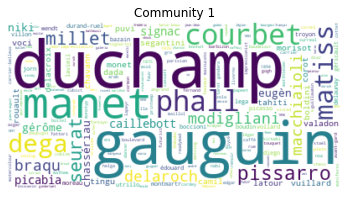

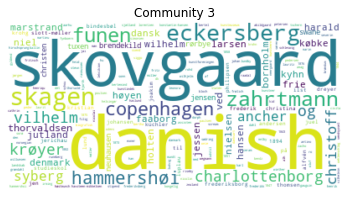

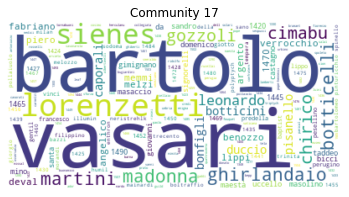

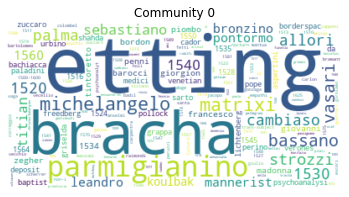

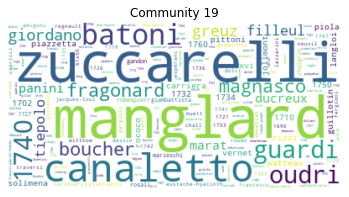

In [80]:
for c in largest_communities:
    c_TF_TR=community_TF_TR[c]
    wordcloud=WordCloud(background_color="white")
    wordcloud.generate_from_frequencies(c_TF_TR['TF-IDF'])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Community "+str(c))
    plt.axis("off")
    plt.savefig(str(c)+'_dcloud.jpg')
    plt.show()

- **Community 1**: Both the word cloud and the highest ranked words consist of painters names. Since the IDF are high
for words which only occure within one document, this is not supprising, as names can be expected to
be some of the most unique words within a document. Looking into the listed painter it can be observed that these are French
painters, with the exception of pissarro(https://en.wikipedia.org/wiki/Camille_Pissarro, vistited 9.12.2020), who is listed as a Danish-French artist.
With connections to different styles, and timeperiods, it appear that community 1 is primarily
charaterized by it's connection to France.

- **Community 3**: From both the network and wordcloud the connection to Denmark is clear. 
Famous painters mentioned within the top-10 such as Ancher, Zahrtmann and Hammershøi,
were all alive and active on the danish art scene around the same time, and it therefore is reasonable
that this is the underlaying connections captures by community 3.  Howewer Eckersberg (https://en.wikipedia.org/wiki/Christoffer_Wilhelm_Eckersberg, visited 9.12.2020) reffere to an earlier
Danish painter, which illustrate that the descirption is not without exceptions.


- **Community 17**: The top-10 highest words mostly reffere to Itallian renaissance painters with the exception of Martini (https://en.wikipedia.org/wiki/Simone_Martini, visited 9.12.2020), who is considered to be connected to the international gothic style. They are all 
noted to have a clear connection to Florence or Siena.
Overall it community 17 can therefore be assumed to capture the painters community in the renaissance
centered around Florence and Siena in Italy.

- **Community 19**: The top-10 highest ranked words mostly reffere to Italian painter. Manglard (https://en.wikipedia.org/wiki/Adrien_Manglard, visited 9.12.2020) and
Fragonard (https://en.wikipedia.org/wiki/Jean-Honor%C3%A9_Fragonard, vistied 9.12.2020) are both French painters, but both visited Italy. An underlying connection 
for the painters in community 19 therefore appeare to be there association with Italy.


- **Community 0**: There can not be observe any clear charateriztics, for community 0
The *etting* and *bracha* appear to be refereing to the conetmperay painter and philosopher
Bracha L. Ettinger (https://en.wikipedia.org/wiki/Bracha_L._Ettinger, visited 9.12.2020).
The remaining painters mentioned are Italian and male and primary active much earlier than the Etting.


### 3.3.3 Community sentiment

We would calculate and store the sentiment for each pages, starting by using the LabMT wordlist (labMT 1.0), which is downloaded below.
Dodds, P. S., Harris, K. D., Kloumann, I. M., Bliss, C. A., Danforth, C. M.(2011) "Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter". https://doi.org/10.1371/journal.pone.0026752 (visited 31.10.2020).

In [81]:
url='https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001'

labMT_wordlist=pd.read_csv(url,'\t',skiprows=3).set_index('word')
labMT_wordlist.head()

,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
word,,,,,,,
laughter,1,8.50,0.9313,3600,--,--,1728
happiness,2,8.44,0.9723,1853,2458,--,1230
love,3,8.42,1.1082,25,317,328,23
happy,4,8.30,0.9949,65,1372,1313,375
laughed,5,8.26,1.1572,3334,3542,--,2332


Then a function will be made to calculate the sentiment based on the score from labMT word list.

In [82]:
def get_sentiment(token_list):
    sentiment=0
    tf=pd.Series(token_list).value_counts()
    tf_total=tf.sum()
     # set of words in documens
    tokens=set(token_list)
    # set of words in LabMT word list
    words=set(labMT_wordlist.index) 
    for t in tokens:
        if t in words:
            sentiment+=(labMT_wordlist.happiness_average[t]*tf[t])/tf_total
    return sentiment

In [83]:
community_sentiment = {}
for c in largest_communities:
    #community_tokens[c]
    try:
        community_sentiment[c]=get_sentiment(community_tokens[c])  
        #print(community_tokens[c])
    except:
        community_sentiment[c] = np.NaN

In [84]:
community_sentiment

{1: 2.7377733642956077,
 3: 2.67418068056624,
 17: 2.6442272867183085,
 0: 2.596621204537872,
 19: 2.5678704696547294}

With sentiments score rangeing from a scale of 1-9 where 1 is very negative and 9 is very happy, and around 5 is consideret neurtal, it can be observed that the communities have negative sentiments. This is expected as the wikipages of painters are only contains neutral descriptions.

### 3.3.4 Community association with cities

The list of city names are extracted by searching over a webpage listing european cities.

In [85]:
url = 'http://ontheworldmap.com/europe/cities/'
response = requests.get(url)
soup = BeautifulSoup(response.text)
city = []

for row in soup.find_all('li'):
    a= row.get_text().strip().replace("\n", "")
    city.append(a)
tindex = city.index('Zwolle')
city = city[:tindex+1]


The next step is to identify which painters have connections to each city. This is here done by serching through each painters wikipidia page, for mentions of each city. Because the list of city, contains citys with names that are also common words, it has been decided that we only search though places linked to from the painters pages

In [86]:
Painters['Visited_cities']=Painters.apply(lambda l: set([connection[0] for connection in (l['connections']) if (connection[0] in city)]),axis=1)
Cities=pd.DataFrame(city,columns=['city'])

For each community we now count how many cities has been visited.

In [87]:
community_Painters_city={}
for c in largest_communities:
    Painters_city=Painters.reset_index(level='Name')
    #Painters_city=Painters_city[Painters_city.Name.isin(partition_whole_network.keys())]
    Painters_city['community']=Painters_city.Name.apply(lambda l: partition_whole_network[l])
    Painters_city=Painters_city[Painters_city.community==c]
    Painters_city=Painters_city.Visited_cities.drop(columns=['Name','community'])
    community_Painters_city[c]=pd.DataFrame(Painters_city)


community_city = {}
for c in largest_communities:
    community_city[c] = Cities.copy()
    community_city[c]['num of painters visited'] = community_city[c].apply(lambda s: community_Painters_city[c][community_Painters_city[c].apply(lambda l:s.city in l.Visited_cities,axis=1)].size,axis=1)
    community_city[c]['num of painters visited scaled'] = community_city[c]['num of painters visited']/len(community_city[c])

We can now compute the 10 most common visited cities within each community.

In [91]:
# 1, 3, 17, 0, 19
print("Top 10 visited cities in Community 1:")
n=1
for i in community_city[1].sort_values(['num of painters visited scaled'],ascending=False)[:10].values:
    print(n,'.',i[0],':',i[2])
    n+=1

Top 10 visited cities in Community 0:
1 . Paris : 0.08786127167630058
2 . Florence : 0.024277456647398842
3 . Copenhagen : 0.017341040462427744
4 . Milan : 0.013872832369942197
5 . Rome : 0.013872832369942197
6 . London : 0.012716763005780347
7 . Naples : 0.011560693641618497
8 . Lyon : 0.010404624277456647
9 . Rouen : 0.010404624277456647
10 . Brussels : 0.009248554913294798


In [92]:
print("Top 10 visited cities in Community 3:")
n=1
for i in community_city[3].sort_values(['num of painters visited scaled'],ascending=False)[:10].values:
    print(n,'.',i[0],':',i[2])
    n+=1

Top 10 visited cities in Community 3:
1 . Copenhagen : 0.10289017341040463
2 . Paris : 0.03005780346820809
3 . Rome : 0.018497109826589597
4 . Dresden : 0.012716763005780347
5 . Florence : 0.010404624277456647
6 . Aarhus : 0.009248554913294798
7 . London : 0.009248554913294798
8 . Odense : 0.008092485549132947
9 . Berlin : 0.008092485549132947
10 . Hamburg : 0.006936416184971098


In [93]:
print("Top 10 visited cities in Community 17:")
n=1
for i in community_city[17].sort_values(['num of painters visited scaled'],ascending=False)[:10].values:
    print(n,'.',i[0],':',i[2])
    n+=1

Top 10 visited cities in Community 17:
1 . Florence : 0.06705202312138728
2 . Rome : 0.03699421965317919
3 . Siena : 0.024277456647398842
4 . Milan : 0.020809248554913295
5 . Pisa : 0.018497109826589597
6 . Venice : 0.017341040462427744
7 . Bologna : 0.016184971098265895
8 . Perugia : 0.013872832369942197
9 . Berlin : 0.010404624277456647
10 . Arezzo : 0.010404624277456647


In [94]:
 print("Top 10 visited cities in Community 0:")
n=1
for i in community_city[0].sort_values(['num of painters visited scaled'],ascending=False)[:10].values:
    print(n,'.',i[0],':',i[2])
    n+=1

Top 10 visited cities in Community 0:
1 . Venice : 0.03236994219653179
2 . Florence : 0.028901734104046242
3 . Rome : 0.021965317919075144
4 . Bologna : 0.011560693641618497
5 . Mantua : 0.010404624277456647
6 . Paris : 0.010404624277456647
7 . Genoa : 0.008092485549132947
8 . Naples : 0.008092485549132947
9 . Madrid : 0.006936416184971098
10 . London : 0.006936416184971098


In [95]:
print("Top 10 visited cities in Community 19:")
n=1
for i in community_city[19].sort_values(['num of painters visited scaled'],ascending=False)[:10].values:
    print(n,'.',i[0],':',i[2])
    n+=1

Top 10 visited cities in Community 19:
1 . Paris : 0.035838150289017344
2 . Venice : 0.019653179190751446
3 . Rome : 0.013872832369942197
4 . Florence : 0.011560693641618497
5 . Vienna : 0.009248554913294798
6 . Naples : 0.009248554913294798
7 . Madrid : 0.008092485549132947
8 . Bologna : 0.006936416184971098
9 . Genoa : 0.006936416184971098
10 . Milan : 0.006936416184971098


We can infer that community 0 will be strongly consists of French painters and community 2 is consists of Danish painters as their capital cities has occupied a big portion in total. 
In community 15 we can distiguish a strong interaction between several famous Italian cities as 'Florence','Rome' and 'Bologna'. Thus, community 15 could be consists mostly of Italian painters.
However, for community 4 and 7 , it will be hard to deduce the composition of them.

## 3.4 Development over time

So far we have been focusing on a static network. However while this provide insites
to how the influence between painters look today, it is imporatant to understand that
the network in reality is not static. The network of painters have slowly evolved over
time, as new painters has entered the art scene, drawing on the influence of
already existing painters. Understanding this development is the focus of this section.

### 3.4.1 Getting the data
When initially identifying painters for the network, information about their birth year
was also extracted. This information will in this section be used as an indicator for
when then a painter entered the art community.


In [96]:
print("Number of painters without year available:",len(Painters[Painters.birth_year=='']))

Number of painters without year available: 51


Since the number of painters with missing birth year is low, these are excluded from this part of the analysis.

In [97]:
Painters_time=Painters[Painters.birth_year!='']

### 3.4.2 Growth of the painters network

To understand the development of the network over time, we are first gonna look
at how the network has grown.

In [98]:
print("The first painter is added to the community in",Painters_time.birth_year.min())
print("The last painter is added to the community in",Painters_time.birth_year.max())

The first painter is added to the community in 1175
The last painter is added to the community in 1990


In [99]:

Painters_time['birth_year']=pd.to_numeric(Painters_time.birth_year)

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


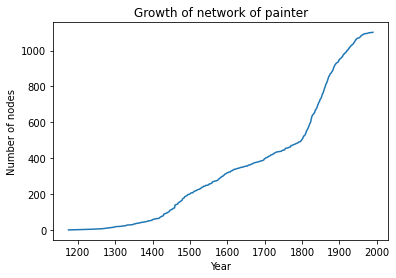

In [100]:
Painters_time_growth=Painters_time.reset_index()
Painters_time_growth['Number_of_nodes']=1
Painters_time_growth=Painters_time_growth.set_index('birth_year')
Painters_time_growth=Painters_time_growth.Number_of_nodes

Painters_time_growth.sort_index().cumsum().groupby("birth_year").max().plot()
plt.title("Growth of network of painter")
plt.xlabel("Year")
plt.ylabel("Number of nodes")
plt.show()

The painters we have information about span over a 800 year period, form the earliest
painter added to the network in 1175 to the last painter added in 1990. It can be observed
that for the first 250 years the network only grew slowy,after which the growth increase for
the next 400 years. At last the networks grew steeply from the beginning of the 19th century
untill the the end of the 20th century.

### 3.4.3 Development of the painters network
In this next step foucs is on illustrate how the network developed.
To do this we will focus on the state of the network at nine times during the time period covert.
The times will be 1220, 1300, 1400, 1500, 1600, 1700, 1800, 1900 and 1990.

In a time perspective a connection between two painters must understood as an influence of an
earlier painter, on a later painter. In other words influence must go forward in time.
To capture this the network will in this section be treated as undirected.

First we plot the networks at each of the selected times.

In [101]:
#Creates the network for a given year.
def get_network(year):
    Painters_time_by_year=Painters_time[Painters_time.birth_year<=year]
    network_year=nx.Graph()
    for painter in Painters_time_by_year.index:
        network_year.add_node(painter)
        network_year.nodes()[painter]["nationality"]=Painters_time.loc[painter,"nationality"]
        for target in Painters_time_by_year.index:     
            #if painter links to target, then add edge between painters
            if Painters_time.loc[target,'wikiLinks'] in Painters_time.loc[painter,'Painter_links']:
                network_year.add_edge(painter, target)
    return network_year


In [102]:
forceatlas2 = ForceAtlas2()

#plot network in subplot
def plot_network(network,year,axs=None):
    axs = axs# or plt.gca
    positions = forceatlas2.forceatlas2_networkx_layout(network)
    nx.draw(network,positions,node_color=[national_color_map[t] for t in [network.nodes()[node]['nationality'] for node in network]],node_size=5,width=0.1,label=nx.get_node_attributes(network,'Nationality'),ax=axs)
    axs.set(title='Year '+str(year))

In [103]:
#creating networks
network_1210=get_network(1210)
network_1300=get_network(1300)
network_1400=get_network(1400)
network_1500=get_network(1500)
network_1600=get_network(1600)
network_1700=get_network(1700)
network_1800=get_network(1800)
network_1900=get_network(1900)
network_1990=get_network(1990)

  0%|          | 0/100 [00:00<?, ?it/s]BarnesHut Approximation  took  0.00  seconds
Repulsion forces  took  0.00  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds
BarnesHut Approximation  took  0.00  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds
BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.03  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds
 21%|██        | 21/100 [00:00<00:00, 208.91it/s]BarnesHut Approximation  took  0.05  seconds
Repulsion forces  took  0.16  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds
 20%|██        | 20/100 [00:00<00:00, 178.74it/s

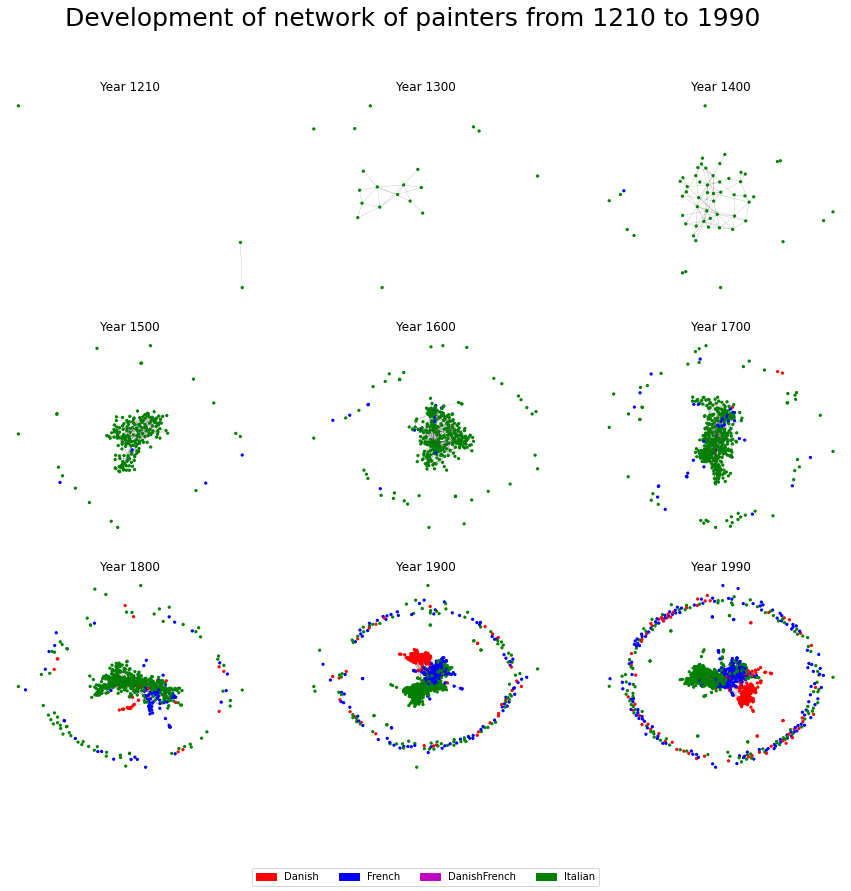

In [104]:
fig, axs = plt.subplots(3,3,figsize=(15,12.5))
fig.suptitle('Development of network of painters from 1210 to 1990',fontsize=25)
axs = axs.ravel()
plot_network(network_1210,1210,axs[0])
plot_network(network_1300,1300,axs[1])
plot_network(network_1400,1400,axs[2])
plot_network(network_1500,1500,axs[3])
plot_network(network_1600,1600,axs[4])
plot_network(network_1700,1700,axs[5])
plot_network(network_1800,1800,axs[6])
plot_network(network_1900,1900,axs[7])
plot_network(network_1990,1990,axs[8])

fig.legend( handles=[mpatches.Patch(color=national_color_map[key],label=key) for key in national_color_map.keys()], loc = 'lower center', ncol=5 ,labelspacing=0.9)
fig.show()
plt.savefig('delv.jpg')

- Berlinghiero Berlinghieri is the earliested listed painter in the network,
 and the only painter present in the network from 1175 unitill 1190.

- In 1210 Bonaventura Berlinghieri is added to the network, and as the son of
 Berlinghiero Berlinghieri creates the first link in the network (https://en.wikipedia.org/wiki/Bonaventura_Berlinghieri vistied 4.12.2020).

- In 1300 the network is still growing slowly, and now contain 19 painters. At this
  point more connections have been established and Duccio is the most connected painter
  with a degree of 5. However at this point most painters are still isolated nodes.

- In 1400 there are 58 painters, and now contains the first non-italial painter;
the french painter Robert Campin, who was added in 1378. At this point we again
see the same pattern, with many painters haveing no connections.

- Over the next hundred years we see that an increase in the growth of the network,
 which has reached 202 nodes by 1500. At this point the network is still dominated
  by Italian painters. But a larger cluster of painters have started to form. And
  only 50 have no connectons.

- 1600: Over the next hundred yeares the network grows to contain 319 painters.
 While still maintainging the same structure consisting of a group of connected
 painters and a number of isolated painters.

 - 1700: 397 painters. Maintining the same structure. We start to see a higher number
  of French painters. In 1608 Abraham Wuchters, who was born in Belgium but had
  most of his career in Denmark(https://en.wikipedia.org/wiki/Abraham_Wuchters, 2.12.202),
   is added to the network as the first Danish painter.

- 1800: 506 painters are in the the network at this point 

- 1900: The network has started to grwow fast, and by 1900 there are 948
 painters in the community. While the overall structure remain the samme, it is worth
  noticing that the number of well connected danish painters has starting to increase.

- 1990: The last painter is added to the network in 1990, resulting in the final network.
The final network consist of a large number of unconnected painters, while the rester are
 strongly connected.

### 3.4.4 Development of degree distributtion

While we have looked at how the number of nodes has grown and how the network
have looked at differen point in time. However to understand how the network has
been formed over time, we must also investigate how connections between painters
have formed. To do this we here look at how the degree distribution of the network
at selected points in time.

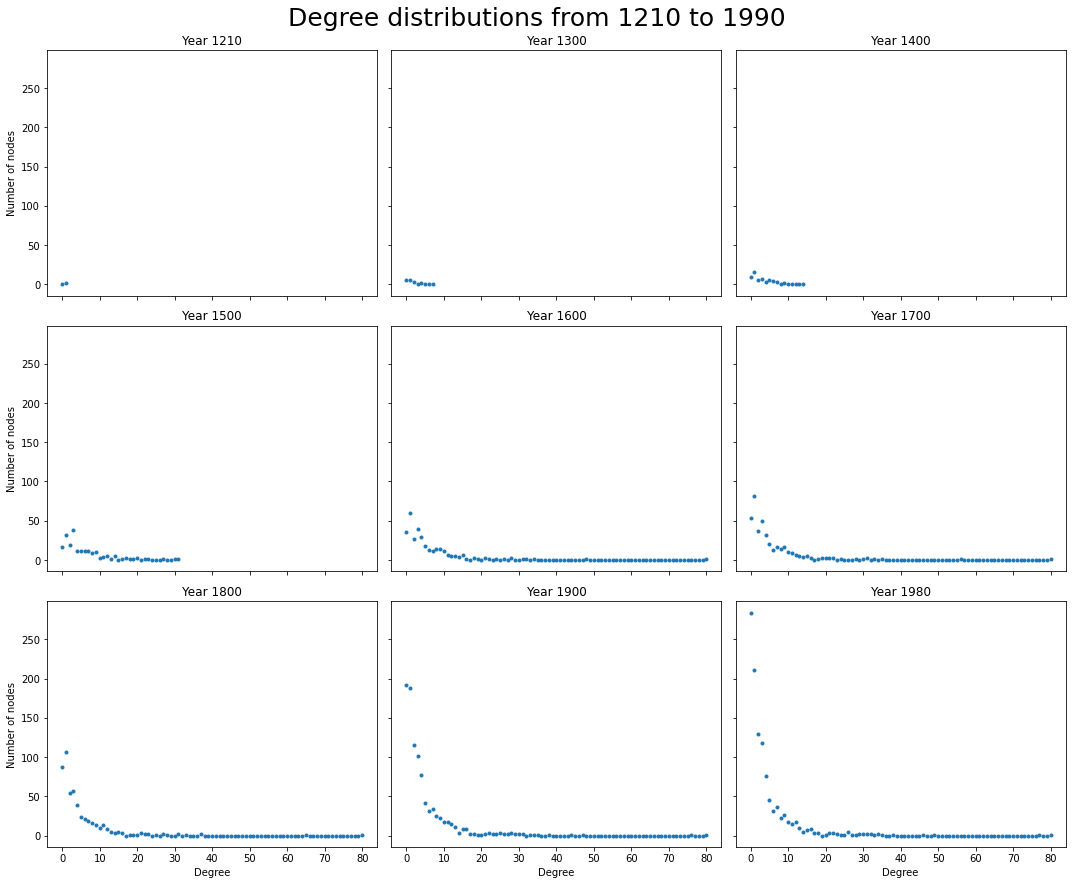

In [105]:
def get_degree_distribution(network,year,axs=None):
    axs = axs or plt.gca
    degrees=[network.degree(p) for p in network]
    degree_count,bins=np.histogram(degrees,bins=np.arange(0,np.max(degrees)+2))
    axs.plot(np.arange(0,np.max(degrees)+1),degree_count,'o',markersize=3)
    axs.set(ylabel='Number of nodes',xlabel='Degree',title='Year '+str(year))

fig, axs = plt.subplots(3,3,figsize=(15,12.5),sharey=True,sharex=True)
fig.suptitle('Degree distributions from 1210 to 1990',fontsize=25)
axs = axs.ravel()
get_degree_distribution(network_1210,1210,axs[0])
get_degree_distribution(network_1300,1300,axs[1])
get_degree_distribution(network_1400,1400,axs[2])
get_degree_distribution(network_1500,1500,axs[3])
get_degree_distribution(network_1600,1600,axs[4])
get_degree_distribution(network_1700,1700,axs[5])
get_degree_distribution(network_1800,1800,axs[6])
get_degree_distribution(network_1900,1900,axs[7])
get_degree_distribution(network_1990,1980,axs[8])

for ax in fig.get_axes():
    ax.label_outer()

fig.tight_layout()

plt.savefig('degree.jpg')


The development of the degree distribution for the network shows that initially there were only connections, with the degrees being low. However, this should also be understood in the context of a low number of nodes. As the network over time increase in size, the low degrees are still the most common, but a few nodes start to have a higher degree. This development corresponds to what would be expected based on preferential attachment. Preferential attachment is described as the phenomenon that nodes prefer to link to nodes that already have a high degree[6].  This results in a few nodes with high degrees and a lot of nodes with low degrees. At the beginning of the development, this corresponds well with what can be observed for the Painters network. However, as time further progress the behavior starts to deviate from what would be expected based on preferential attachment. The highest degree stops growing, and from 1600 to 1990 the maximum degree remains constant at 76. Here we would have expected continuous growth in the maximum degree, as the nodes with the highest degrees would have the highest chance of being linked to by new nodes. However, this behavior should also be seen in the light of an incomplete network, in the sense that the list of painters which have been included in reality only represent a small subset of all painters.

# 4. Discussion
The created network of painters illustrated the overall painters community well, and the internally identified
communities allowed for was meaningfully charaterized through the use of text analysis, allowing 
for insights into what forms these internal communites.<br>
However while the chosen nations provided insights into the European painters community,
the inclusion of the additional European nations countries would be necessary in order to
obtain a complete representation. The inclusion of additional countries would also allow
an exploration of potential new geographical communites, such as the scandinavian- or
East european painters network.<be>
At last further investigation into what formes international connections, would be necessary.
Throughout the analysis nationality appeared to have been an important factor when formining communities. However
when more than one nationality appeared within a community, there were often a shared connection
to a geographical location. The identification of which locations where of special importance in
termes of creating such connections could be the topic of further investigations.

# 5. Contributions


![Contribution table](image-20201209-144950.png)